#### Data analysis for DIA-NN and Full-DIA result on test datasets

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
plt.style.use('default')
plt.rcParams['font.family'] = 'Arial'
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

In [2]:
report_dir1 = Path('../../reports/Plasma')
report_dir2 = Path('../../reports/SC-293T')
report_dir3 = Path('../../reports/SC-LPS')
report_dir4 = Path('../../reports/SC-Cycle')

reports_dir = np.array([report_dir1, report_dir2, report_dir3, report_dir4])
datasets_id = np.array(['Plasma', 'SC-293T', 'SC-LPS', 'SC-Cycle'])

# reports_dir = reports_dir[[0, 0, 1]]
# datasets_id = datasets_id[[0, 0, 1]]

In [3]:
# functions for ids
def cal_tp_fp(ws, level):
    df = pd.read_parquet(ws/'report.parquet', engine='fastparquet')

    if level == 'pg':
        df = df[df['Global.PG.Q.Value'] < 0.01]
        df['species'] = df['Protein.Names'].apply(
            lambda row: ';'.join(
                set([part.split('_')[1] for part in row.split(';')]))
        )
        df = df[df['species'].str.count(';') == 0]
        tp = df[df['species'] != 'ARATH']['Protein.Group'].nunique()
        fp = df[df['species'] == 'ARATH']['Protein.Group'].nunique()

    if level == 'pr':
        df = df[df['Global.Q.Value'] < 0.01]
        df['species'] = df['Protein.Names'].apply(
            lambda row: ';'.join(
                set([part.split('_')[1] for part in row.split(';')]))
        )
        df = df[df['species'].str.count(';') == 0]
        tp = df[df['species'] != 'ARATH']['Precursor.Id'].nunique()
        fp = df[df['species'] == 'ARATH']['Precursor.Id'].nunique()
    return tp, fp, fp/(tp + 1e-6)

def make_id_df(ws_v, ws_ids, level):
    dataset_v, method_v = [], []
    TP_v, FP_v, fdr_v = [], [], []
    for ws, ws_id in zip(ws_v, ws_ids):
        print(ws_id)
        for method in ['diann_220', 'full_100']:
            tp, fp, fdr = cal_tp_fp(ws / method, level)
            dataset_v.append(ws_id)
            method_v.append(method)
            TP_v.append(tp)
            FP_v.append(fp)
            fdr_v.append(fdr)
    df = pd.DataFrame()
    df['dataset'] = dataset_v
    df['method'] = method_v
    df['TP'] = TP_v
    df['FP'] = FP_v
    df['FDR'] = fdr_v
    return df

#### ids-pr

In [4]:
df = make_id_df(reports_dir, datasets_id, 'pr')

grouped = df.groupby('method')
x = grouped.get_group('diann_220')['TP'].values
y = grouped.get_group('full_100')['TP'].values
gains = (y - x) / x

print(gains)
print(df.copy())

Plasma
SC-293T
SC-LPS
SC-Cycle
[0.13504823 0.32214022 0.5492547  0.14173551]
    dataset     method     TP   FP       FDR
0    Plasma  diann_220  12440   37  0.002974
1    Plasma   full_100  14120  189  0.013385
2   SC-293T  diann_220  13550   91  0.006716
3   SC-293T   full_100  17915  178  0.009936
4    SC-LPS  diann_220   9258    0  0.000000
5    SC-LPS   full_100  14343    0  0.000000
6  SC-Cycle  diann_220  17067    0  0.000000
7  SC-Cycle   full_100  19486    0  0.000000


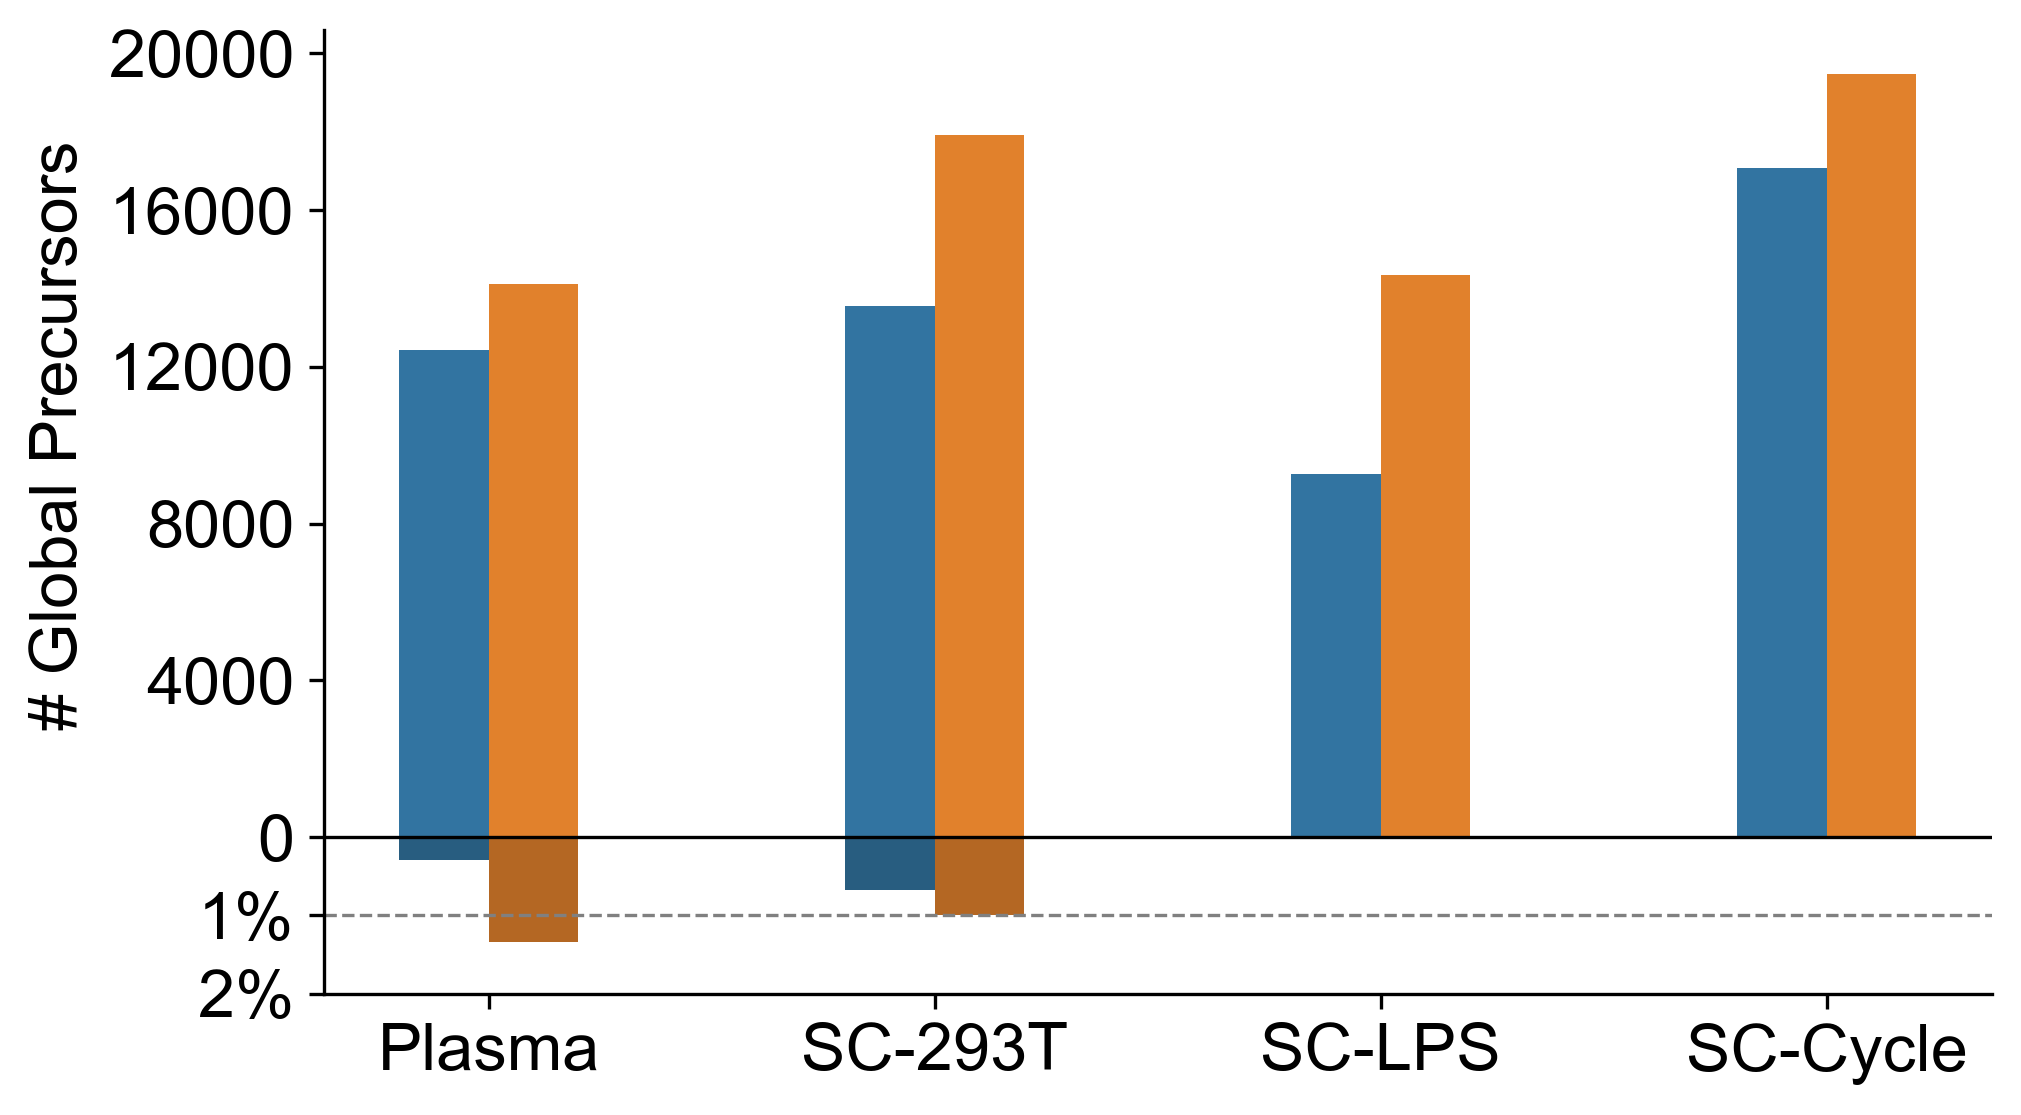

In [5]:
from matplotlib.ticker import FuncFormatter

up_colors = {"diann_220": "#3274a1", "full_100": "#e1812c"}
down_colors = {"diann_220": "#285d80", "full_100": "#b46723"}

width = 0.3
scaling_factor = 200000
n_dataset = int(len(df) / 2)
x = np.arange(n_dataset) * 1.5

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(7, 4))

for method in df['method'].unique():
    offset = -width/2 if method == "diann_220" else width/2
    tp_v = df.loc[df['method'] == method, 'TP'].values
    fdr_v = df.loc[df['method'] == method, 'FDR'].values * scaling_factor
    ax.bar(x + offset, tp_v, width, color=up_colors[method])
    ax.bar(x + offset, -fdr_v, width, color=down_colors[method])

ax.set_xticks(x)
ax.set_xticklabels(df['dataset'].values[::2], rotation=0)
ax.axhline(0, color="black", linewidth=0.8)
ax.axhline(-0.01*scaling_factor, color='grey', linewidth=0.8, linestyle='--')

ax.set_ylim(-0.02 * scaling_factor, None)
def custom_formatter(y, _):
    if y < 0:
        return f'{-y*100/scaling_factor:.0f}%'
    return f'{y:.0f}'
ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))
y_min, y_max = ax.get_ylim()
y_ticks = np.concatenate([
    np.arange(np.floor(y_min), 0, 0.01*scaling_factor),
    np.arange(0, y_max, 4000)
])
ax.set_yticks(y_ticks)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel("# Global Precursors")
ax.yaxis.set_label_coords(-0.14, 0.58)

ax.tick_params(axis='y', which='both')
ax.grid(False)
plt.tight_layout()
plt.show()

#### ids-pg

In [6]:
df = make_id_df(reports_dir, datasets_id, 'pg')

grouped = df.groupby('method')
x = grouped.get_group('diann_220')['TP'].values
y = grouped.get_group('full_100')['TP'].values
gains = (y - x) / x

print(gains)
print(df.copy())

Plasma
SC-293T
SC-LPS
SC-Cycle
[ 0.01221498  0.06907631  0.19360902 -0.0399106 ]
    dataset     method    TP  FP       FDR
0    Plasma  diann_220  1228   9  0.007329
1    Plasma   full_100  1243  13  0.010459
2   SC-293T  diann_220  2490  38  0.015261
3   SC-293T   full_100  2662  44  0.016529
4    SC-LPS  diann_220  1596   0  0.000000
5    SC-LPS   full_100  1905   0  0.000000
6  SC-Cycle  diann_220  3132   0  0.000000
7  SC-Cycle   full_100  3007   0  0.000000


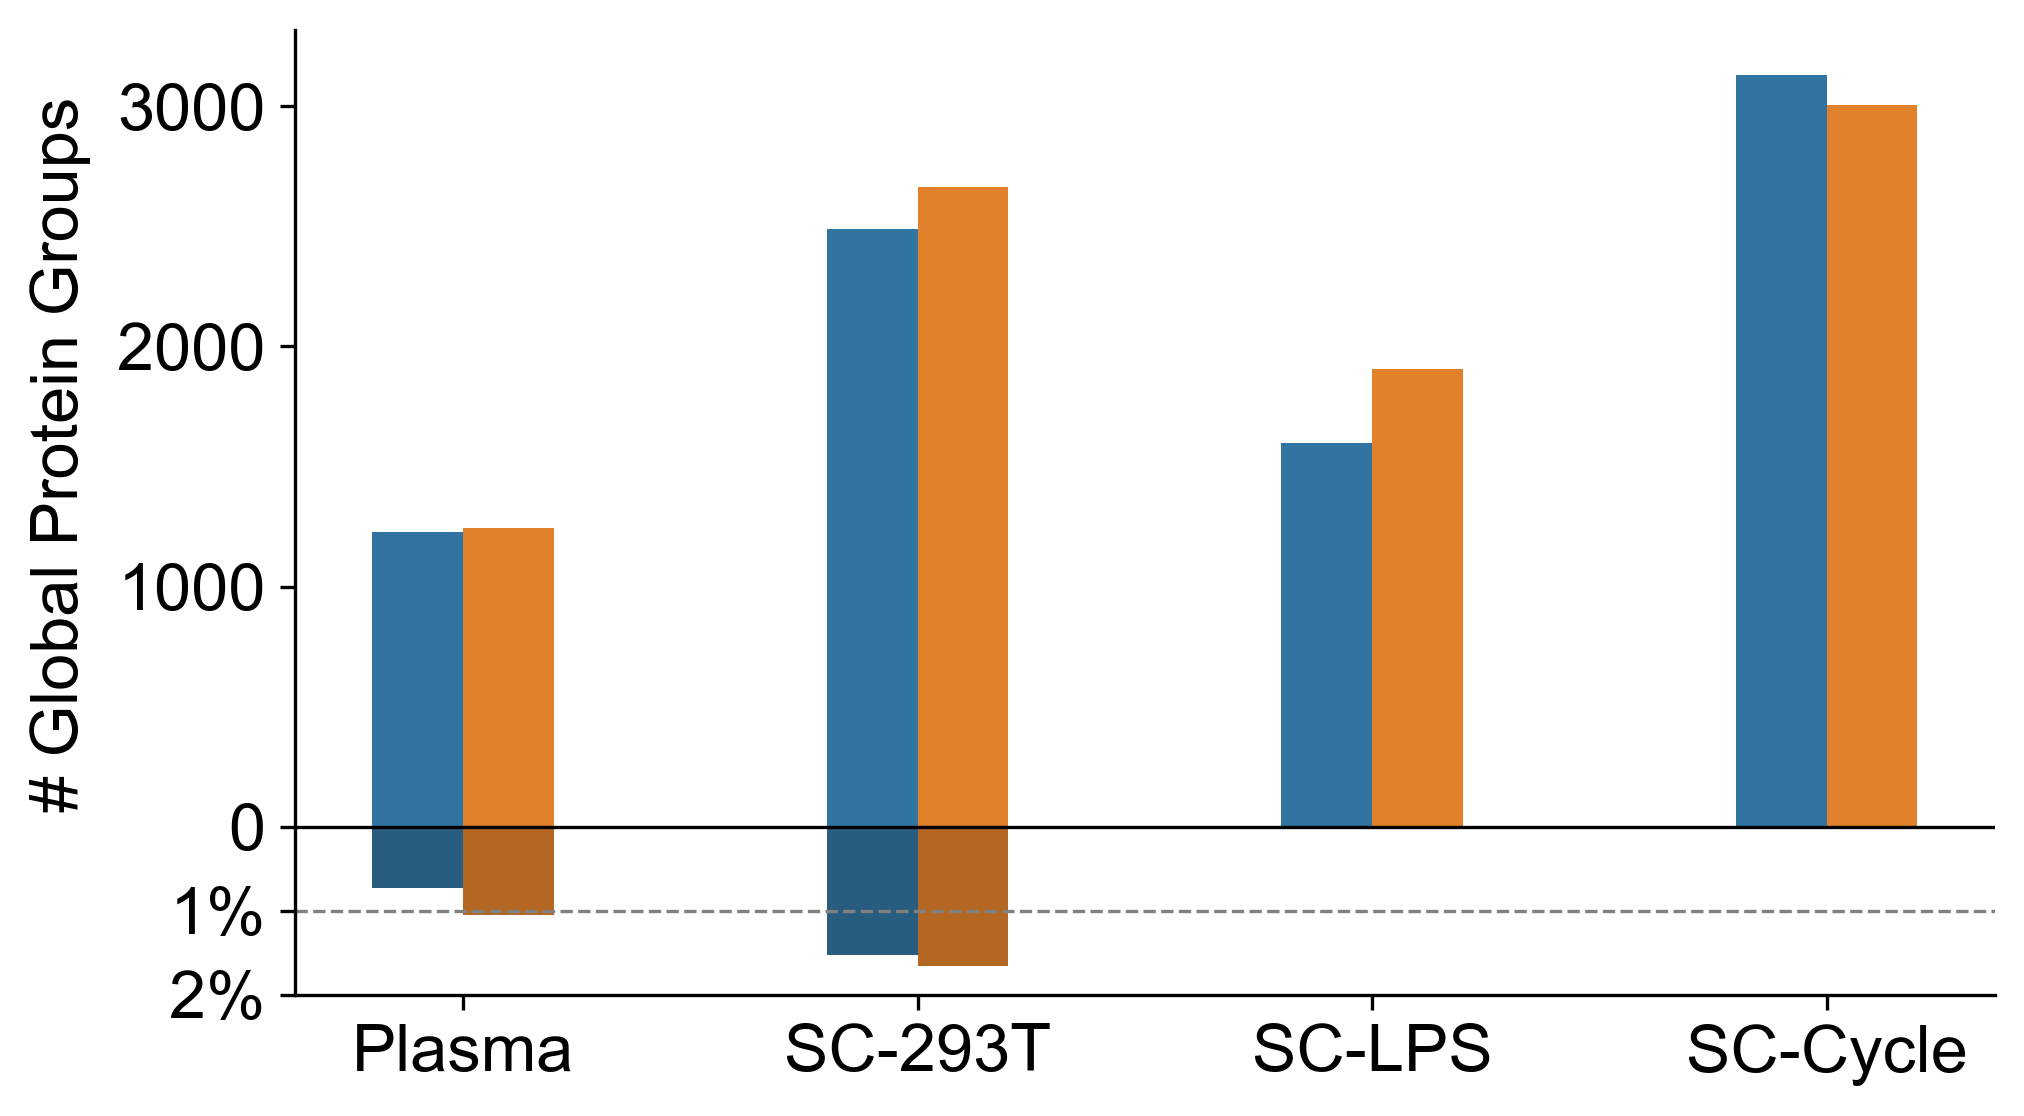

In [7]:
up_colors = {"diann_220": "#3274a1", "full_100": "#e1812c"}
down_colors = {"diann_220": "#285d80", "full_100": "#b46723"}

width = 0.3
scaling_factor = 35000
n_dataset = int(len(df) / 2)
x = np.arange(n_dataset) * 1.5

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(7, 4))

for method in df['method'].unique():
    offset = -width/2 if method == "diann_220" else width/2
    tp_v = df.loc[df['method'] == method, 'TP'].values
    fdr_v = df.loc[df['method'] == method, 'FDR'].values * scaling_factor
    ax.bar(x + offset, tp_v, width, color=up_colors[method])
    ax.bar(x + offset, -fdr_v, width, color=down_colors[method])

ax.set_xticks(x)
ax.set_xticklabels(df['dataset'].values[::2], rotation=0)
ax.axhline(0, color="black", linewidth=0.8)
ax.axhline(-0.01*scaling_factor, color='grey', linewidth=0.8, linestyle='--')

ax.set_ylim(-0.02 * scaling_factor, None)
def custom_formatter(y, _):
    if y < 0:
        return f'{-y*100/scaling_factor:.0f}%'
    return f'{y:.0f}'
ax.yaxis.set_major_formatter(FuncFormatter(custom_formatter))
y_min, y_max = ax.get_ylim()
y_ticks = np.concatenate([
    np.arange(np.floor(y_min), 0, 0.01*scaling_factor),
    np.arange(0, y_max, 1000)
])
ax.set_yticks(y_ticks)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel("# Global Protein Groups")
ax.yaxis.set_label_coords(-0.12, 0.56)
ax.tick_params(axis='y', which='both')
ax.grid(False)
plt.tight_layout()
plt.show()

#### time

In [8]:
from datetime import timedelta

def cal_time(ws):
    if str(ws).__contains__('diann'):
        with open(ws / 'report.log.txt') as f:
            lines = f.readlines()
            time_str = lines[-2].split(' ')[0][1:-1]
            total_minutes = int(time_str.split(':')[0]) + int(
                time_str.split(':')[-1]) / 60
            n = int(lines[-20].split(' ')[-2])
    if str(ws).__contains__('full'):
        with open(ws / 'report.log.txt') as f:
            lines = f.readlines()
            time_str = lines[-1].split(' ')[0][:-1]
            h, m, s = map(int, time_str.split(':'))
            duration = timedelta(hours=h, minutes=m, seconds=s)
            total_minutes = duration.total_seconds()/60.
            n = int(lines[-10].split(' ')[2])
    return total_minutes / n

def make_time_df(ws_v, ws_ids):
    dataset_v, method_v, time_v = [], [], []
    for ws, ws_id in zip(ws_v, ws_ids):
        print(ws_id)
        for method in ['diann_220', 'full_100']:
            time = cal_time(ws / method)
            dataset_v.append(ws_id)
            method_v.append(method)
            time_v.append(time)
    df = pd.DataFrame()
    df['dataset'] = dataset_v
    df['method'] = method_v
    df['time'] = time_v
    return df

df = make_time_df(reports_dir, datasets_id)
df.copy()

Plasma
SC-293T
SC-LPS
SC-Cycle


,dataset,method,time
0,Plasma,diann_220,58.844444
1,Plasma,full_100,37.077778
2,SC-293T,diann_220,24.356250
3,SC-293T,full_100,22.658333
4,SC-LPS,diann_220,22.076146
5,SC-LPS,full_100,15.231458
6,SC-Cycle,diann_220,9.537918
7,SC-Cycle,full_100,12.057424


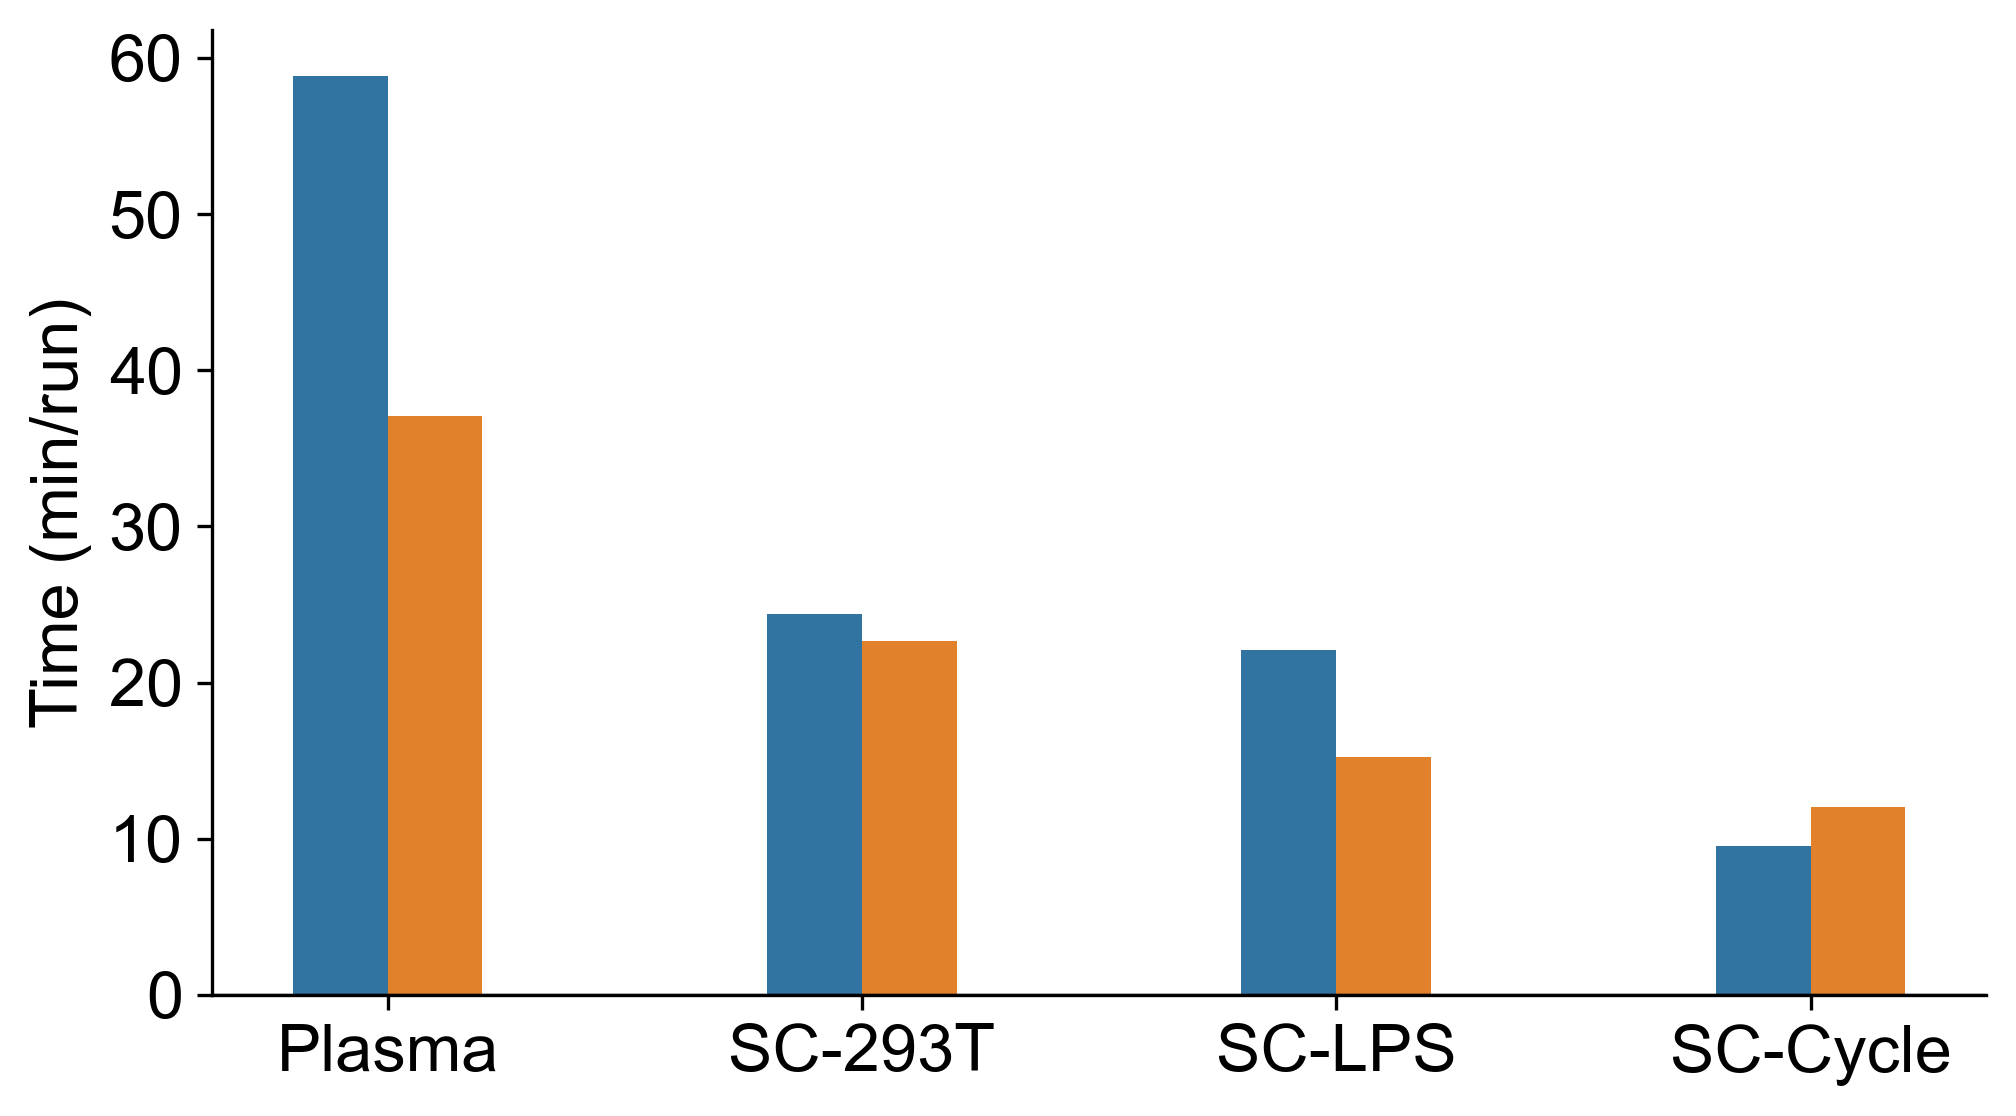

In [9]:
up_colors = {"diann_220": "#3274a1", "full_100": "#e1812c"}
down_colors = {"diann_220": "#285d80", "full_100": "#b46723"}

width = 0.3
n_dataset = int(len(df) / 2)
x = np.arange(n_dataset) * 1.5

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(7, 4))

for method in df['method'].unique():
    offset = -width/2 if method == "diann_220" else width/2
    time_v = df.loc[df['method'] == method, 'time'].values
    ax.bar(x + offset, time_v, width, color=up_colors[method])

ax.set_xticks(x)
ax.set_xticklabels(df['dataset'].values[::2], rotation=0)
ax.axhline(0, color="black", linewidth=0.8)

# yticks = ax.get_yticks()
# ax.set_yticklabels([abs(int(tick)) for tick in yticks])

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

ax.set_ylabel("Time (min/run)")

ax.tick_params(axis='y', which='both')
ax.grid(False)
plt.tight_layout()
plt.show()